---
title: py4DSTEM Parallax
authors: [Georgios Varnavides]
date: 2024/07/18
---

### Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import py4DSTEM

import ipywidgets
from IPython.display import display
import jupyter_capture_output

style = {'description_width': 'initial'}

Jupyter Capture Output v0.0.11


### Load Data

In [2]:
file_path = 'data/'
file_data_01 = file_path + 'parallax_apoferritin_simulation_100eA2_01.h5'
file_data_02 = file_path + 'parallax_apoferritin_simulation_100eA2_02.h5'

dataset_01 = py4DSTEM.read(file_data_01)
dataset_02 = py4DSTEM.read(file_data_02)
dataset = py4DSTEM.DataCube(np.hstack((dataset_01.data,dataset_02.data)),calibration=dataset_01.calibration)
dataset

DataCube( A 4-dimensional array of shape (24, 48, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

### Basic Visualizations

In [3]:
mean_diffraction_pattern = dataset.get_dp_mean().data
mean_diffraction_pattern /= mean_diffraction_pattern.max()
bright_field_mask = mean_diffraction_pattern > 0.5
bright_field_mask_indices_vertical, bright_field_mask_indices_horizontal = np.where(bright_field_mask)

reciprocal_sampling = dataset.calibration.get_Q_pixel_size()
reciprocal_units = dataset.calibration.get_Q_pixel_units()
reciprocal_kwargs = {"pixelsize":reciprocal_sampling,"pixelunits":reciprocal_units,"scalebar":{"length":5},"ticks":False}

virtual_bright_field_images = dataset[:,:,bright_field_mask].transpose(2,0,1)
gridscan_sampling = dataset.calibration.get_R_pixel_size()
real_kwargs = {"pixelsize":gridscan_sampling/10,"pixelunits":"nm","scalebar":{"color":"black","length":10},"ticks":False}

In [4]:
def return_axial_image_and_mask(axial_r):
    """ """
    axial_bf_indices = np.unravel_index(
        np.argwhere(
            np.linalg.norm(
                np.argwhere(np.ones_like(bright_field_mask)) - np.array(bright_field_mask.shape)[None]/2,
                axis=1
            ) < axial_r
        ),
        bright_field_mask.shape
    )     
    
    axial_bf_image = dataset[:,:,axial_bf_indices[0],axial_bf_indices[1]].sum((-2,-1))
    bright_field_mask_rgb = np.zeros(bright_field_mask.shape+(3,))
    
    # cyan
    bright_field_mask_rgb[bright_field_mask,1:] =1 
    
    # magenta
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],0]=1
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],1]=0
    bright_field_mask_rgb[axial_bf_indices[0],axial_bf_indices[1],2]=1

    return axial_bf_image, bright_field_mask_rgb


def update_axial_image_and_mask(change):
    axial_r = change["new"]
    axial_bf_image, bright_field_mask_rgb = return_axial_image_and_mask(axial_r)

    axial_artists[0].set_data(bright_field_mask_rgb)
    
    _axial_bf_image, _vmin, _vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(axial_bf_image)
    axial_artists[1].set_data(_axial_bf_image)
    axial_artists[1].set_clim(vmin=_vmin, vmax=_vmax)
    
    fig_axial.canvas.draw_idle()
    return None

axial_r_slider = ipywidgets.IntSlider(min=1, max=26, step=1, style=style, description="axial virtual BF radius")
axial_r_slider.observe(update_axial_image_and_mask,names='value')

In [5]:
with plt.ioff():
    dpi = 72
    fig_axial = plt.figure(figsize=(675/dpi, 360/dpi), dpi=dpi)

gs = GridSpec(2, 2, wspace=0.05)
ax_bf_disk = fig_axial.add_subplot(gs[:, 0])
ax_axial = fig_axial.add_subplot(gs[0, 1])
ax_incoherent = fig_axial.add_subplot(gs[1, 1])

axial_bf_image, bright_field_mask_rgb = return_axial_image_and_mask(axial_r=1)
py4DSTEM.show(
    bright_field_mask_rgb,
    figax=(fig_axial,ax_bf_disk),
    **reciprocal_kwargs,
    title="bright field disk mask",
)

py4DSTEM.show(
    axial_bf_image,
    figax=(fig_axial,ax_axial),
    **real_kwargs,
    cmap='Greys',
    title="virtual (axial) bright field image",
    bordercolor="magenta",
    borderwidth=2,
)

py4DSTEM.show(
    virtual_bright_field_images.sum(0),
    figax=(fig_axial,ax_incoherent),
    **real_kwargs,
    cmap='Greys',
    title="incoherent bright field image",
    bordercolor="cyan",
    borderwidth=2,
)

gs.tight_layout(fig_axial)
axial_artists = [ax_bf_disk.get_images()[0],ax_axial.get_images()[0]]

fig_axial.canvas.resizable = False
fig_axial.canvas.header_visible = False
fig_axial.canvas.footer_visible = False
fig_axial.canvas.toolbar_visible = True
fig_axial.canvas.layout.width = '675px'
fig_axial.canvas.layout.height = '390px'
fig_axial.canvas.toolbar_position = 'bottom'

In [6]:
#| label: app:py4dstem_parallax_vbfs

display(
    ipywidgets.VBox(
        [
            axial_r_slider,
            fig_axial.canvas
        ],
        layout=ipywidgets.Layout(align_items='center',width='675px'))
)

### Iterative Alignment Bins

In [7]:
def return_bf_bins(bf_mask, bin_value, shift=0):
    """ """
    _xy_inds = np.argwhere(bf_mask)
    _xy_center = (_xy_inds - np.mean(_xy_inds, axis=0)).astype("float")
    _xy_inds_binned = np.round(_xy_center / bin_value + shift).astype("int")
    _xy_vals_binned = np.unique(_xy_inds_binned, axis=0)
    _inds_order = np.argsort(np.sum(_xy_vals_binned**2, axis=1))
    
    masks = np.zeros((_inds_order.shape[0],)+bf_mask.shape)
    for ind, bin_ind in enumerate(_inds_order):
        sub = np.logical_and(
            _xy_inds_binned[:, 0] == _xy_vals_binned[bin_ind, 0],
            _xy_inds_binned[:, 1] == _xy_vals_binned[bin_ind, 1],
        )
        indexing_i, indexing_j = _xy_inds[sub].T
        masks[ind,indexing_i,indexing_j]=1
    return masks

def return_bf_bins_rgb(bf_mask, bin_value, shift=0):
    """ """
    bins=return_bf_bins(bf_mask, bin_value, shift=shift)
    n = bins.shape[0]
    hue_angles = np.linspace(0.0, 2.0 * np.pi, n, endpoint=False)
    complex_arr = np.tensordot(np.exp(1j*hue_angles),bins,axes=1)
    return py4DSTEM.visualize.Complex2RGB(complex_arr)

bins_32 = return_bf_bins_rgb(bright_field_mask,32)
bins_16 = return_bf_bins_rgb(bright_field_mask,16)
bins_8 = return_bf_bins_rgb(bright_field_mask,8)
bins_4 = return_bf_bins_rgb(bright_field_mask,4)
bins_2 = return_bf_bins_rgb(bright_field_mask,2)
bins_1 = return_bf_bins_rgb(bright_field_mask,1)

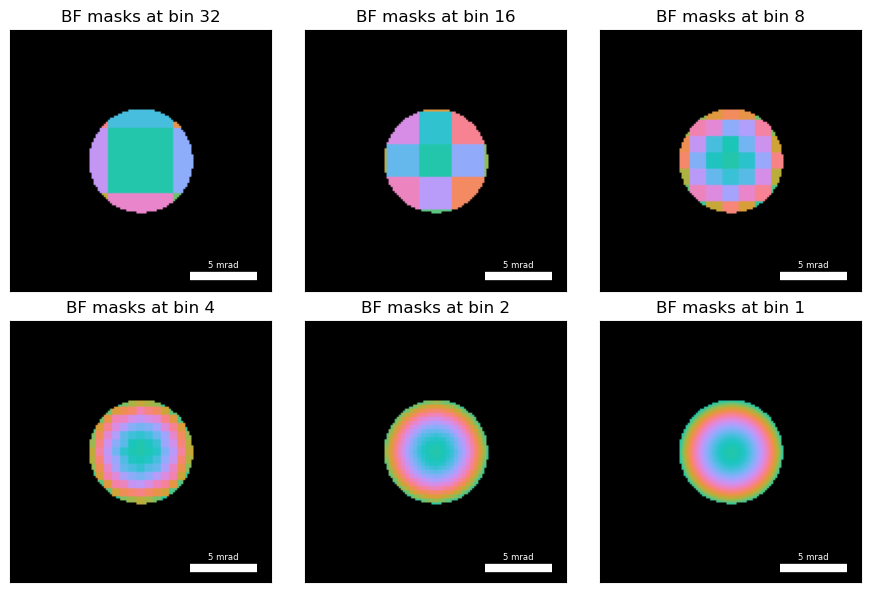

In [8]:
#| label: app:py4dstem_parallax_masks
with plt.ioff():
    py4DSTEM.show(
        [
            [bins_32, bins_16, bins_8],
            [bins_4, bins_2, bins_1]
        ],
        axsize=(3,3),
        **reciprocal_kwargs,
        title=[f"BF masks at bin {it}" for it in [32,16,8,4,2,1]]
    )
    fig_masks = plt.gcf()
fig_masks

### py4DSTEM Reconstruct

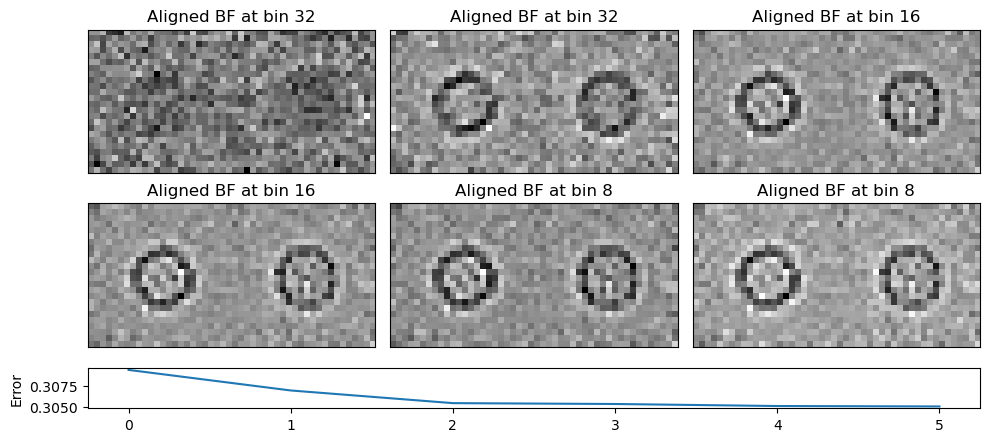

In [9]:
#| label: app:py4dstem_parallax_reconstruct

with plt.ioff():
    parallax = py4DSTEM.process.phase.Parallax(
        datacube=dataset,
        energy = 300e3,
        object_padding_px=(8,8),
    ).preprocess(
        edge_blend=4,
        plot_average_bf=False,
    ).reconstruct(
        alignment_bin_values=[32,32,16,16,8,8],
        progress_bar=False,
        figsize=(10,4.5),
        cmap='gray',
    )
    fig_reconstruct = plt.gcf()
fig_reconstruct

### Measured Cross Corellation Shifts

In [10]:
def return_plot_ind(
    gpts=parallax._region_of_interest_shape,
    dp_mask=parallax._dp_mask,
    plot_arrow_freq=1
):
    """ """
    dp_mask_ind = np.nonzero(dp_mask)
    xx, yy = np.meshgrid(np.arange(gpts[0]),np.arange(gpts[1]),indexing='ij')
    freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
    masked_ind = np.logical_and(freq_mask, dp_mask)
    plot_ind = masked_ind[dp_mask_ind]
    
    return plot_ind

def return_static_quiver_plot(kxy, uv, plot_ind, ax, title="predicted bright field shifts"):
    """ """
    
    quiver = ax.quiver(
        kxy[plot_ind, 1],
        kxy[plot_ind, 0],
        uv[plot_ind,1],
        uv[plot_ind,0],
        angles="xy",
        scale_units="xy",
        scale=1,
        color='red'
    )
    
    kr_max = np.linalg.norm(kxy,axis=1).max()
    ax.set_xlim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_ylim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_title(title)
    ax.set_ylabel(r"$k_x$ [$A^{-1}$]")
    ax.set_xlabel(r"$k_y$ [$A^{-1}$]")
    ax.set_aspect("equal")

    return quiver

In [11]:
kxy = parallax._kxy
measured_shifts = parallax._xy_shifts * np.array(parallax._reciprocal_sampling)[None]
plot_ind = return_plot_ind(plot_arrow_freq=4)

with plt.ioff():
    dpi = dpi
    measured_quiver_fig, measured_quiver_ax = plt.subplots(figsize=(350/dpi,350/dpi), dpi=dpi)

measured_quiver = return_static_quiver_plot(
    kxy,
    measured_shifts,
    plot_ind,
    measured_quiver_ax,
    title="measured bright field shifts"
)

measured_quiver_fig.canvas.resizable = False
measured_quiver_fig.canvas.header_visible = False
measured_quiver_fig.canvas.footer_visible = False
measured_quiver_fig.canvas.toolbar_visible = True
measured_quiver_fig.canvas.layout.width = '350px'
measured_quiver_fig.canvas.layout.height = '380px'
measured_quiver_fig.canvas.toolbar_position = 'bottom'
measured_quiver_fig.tight_layout()

def update_measured_quiver(change):
    plot_arrow_freq = change["new"]
    plot_ind = return_plot_ind(plot_arrow_freq=plot_arrow_freq)
    new_shifts = measured_shifts[plot_ind]
    new_kxy = kxy[plot_ind]

    measured_quiver.N = new_kxy.shape[0]
    measured_quiver.XY = np.fliplr(new_kxy)
    measured_quiver.set_offsets(np.fliplr(new_kxy))
    measured_quiver.set_UVC(new_shifts[:,1],new_shifts[:,0])
    
    measured_quiver_fig.canvas.draw_idle()
    return None

arrow_freq_slider_measured = ipywidgets.IntSlider(min=1, max=16, step=1, value=4, style=style, description="plot arrow frequency")
arrow_freq_slider_measured.observe(update_measured_quiver,names='value')

In [12]:
#| label: app:py4dstem_parallax_shifts

display(
    ipywidgets.VBox(
        [
            arrow_freq_slider_measured,
            measured_quiver_fig.canvas
        ],
        layout=ipywidgets.Layout(align_items='center',width='400px'))
)

### Predicted Cross Correlation Shifts

In [13]:
def calculate_aberration_gradient_basis(
    sampling,
    gpts,
    wavelength,
    rotation_angle=0,
):
    """ """
    sx, sy = sampling
    nx, ny = gpts
    qx = np.fft.fftfreq(nx,sx)
    qy = np.fft.fftfreq(ny,sy)
    qx, qy = np.meshgrid(qx, qy, indexing="ij")

    # passive rotation
    qx, qy = qx * np.cos(-rotation_angle) + qy * np.sin(
        -rotation_angle
    ), -qx * np.sin(-rotation_angle) + qy * np.cos(-rotation_angle)

    # coordinate system
    qr2 = qx**2 + qy**2
    u = qx * wavelength
    v = qy * wavelength
    alpha = np.sqrt(qr2) * wavelength
    theta = np.arctan2(qy, qx)

    _aberrations_mn = [[1,0,0],[1,2,0],[1,2,1],[2,1,0],[2,1,1],[3,0,0]]
    _aberrations_n = len(_aberrations_mn)
    _aberrations_basis = np.zeros((alpha.size, _aberrations_n))
    _aberrations_basis_du = np.zeros((alpha.size, _aberrations_n))
    _aberrations_basis_dv = np.zeros((alpha.size, _aberrations_n))

    for a0 in range(_aberrations_n):
        m, n, a = _aberrations_mn[a0]

        if n == 0:
            # Radially symmetric basis
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (u * alpha ** (m - 1)).ravel()
            _aberrations_basis_dv[:, a0] = (v * alpha ** (m - 1)).ravel()

        elif a == 0:
            # cos coef
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) * np.cos(n * theta) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * u * np.cos(n * theta) + n * v * np.sin(n * theta))
                / (m + 1)
            ).ravel()
            _aberrations_basis_dv[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * v * np.cos(n * theta) - n * u * np.sin(n * theta))
                / (m + 1)
            ).ravel()

        else:
            # sin coef
            _aberrations_basis[:, a0] = (
                alpha ** (m + 1) * np.sin(n * theta) / (m + 1)
            ).ravel()
            _aberrations_basis_du[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * u * np.sin(n * theta) - n * v * np.cos(n * theta))
                / (m + 1)
            ).ravel()
            _aberrations_basis_dv[:, a0] = (
                alpha ** (m - 1)
                * ((m + 1) * v * np.sin(n * theta) + n * u * np.cos(n * theta))
                / (m + 1)
            ).ravel()

    # global scaling
    _aberrations_basis *= 2 * np.pi / wavelength
    
    return _aberrations_basis, _aberrations_basis_du, _aberrations_basis_dv

def return_estimated_shifts_and_chi(
    sampling=parallax._scan_sampling,
    gpts=parallax._region_of_interest_shape,
    wavelength=parallax._wavelength,
    xy_inds=parallax._xy_inds,
    reciprocal_sampling=parallax._reciprocal_sampling,
    rotation_angle_deg=0,
    defocus=0,
    astigmatism=0,
    astigmatism_angle_deg=0,
    coma=0,
    coma_angle_deg=0,
    spherical_aberration=0,
):
    """ """
    astigmatism_x = astigmatism * np.cos(np.deg2rad(astigmatism_angle_deg) * 2)
    astigmatism_y = astigmatism * np.sin(np.deg2rad(astigmatism_angle_deg) * 2)
    coma_x = coma * np.cos(np.deg2rad(coma_angle_deg) * 1)
    coma_y = coma * np.sin(np.deg2rad(coma_angle_deg) * 1)
    _aberrations_coefs = np.array([-defocus,astigmatism_x,astigmatism_y,coma_x,coma_y,spherical_aberration])
    
    _aberrations_basis, _aberrations_basis_du, _aberrations_basis_dv = calculate_aberration_gradient_basis(
        sampling,
        gpts,
        wavelength,
        rotation_angle=np.deg2rad(rotation_angle_deg),
    )

    chi = np.tensordot(_aberrations_basis,_aberrations_coefs,axes=1).reshape(gpts)
    corner_indices = xy_inds - np.array(gpts)//2
    raveled_indices = np.ravel_multi_index(corner_indices.T, gpts, mode="wrap")
    gradients = np.array(
        (
            _aberrations_basis_du[raveled_indices, :],
            _aberrations_basis_dv[raveled_indices, :],
        )
    )
    shifts = np.tensordot(gradients,-_aberrations_coefs,axes=1)*np.array(reciprocal_sampling)[:,None]
    
    return shifts.T, chi

initial_stack_fft = np.fft.fft2(parallax._stack_BF_shifted_initial)
def apply_shifts_to_stack(
    shifts,
    reciprocal_sampling = parallax._reciprocal_sampling
):
    dx, dy = shifts.T / np.array(reciprocal_sampling)[:,None]
    shift_op = np.exp(
        parallax._qx_shift[None] * dx[:, None, None]
        + parallax._qy_shift[None] * dy[:, None, None]
    )
    shifted_aligned = np.real(np.fft.ifft2(initial_stack_fft * shift_op)).mean(0)
    
    return parallax._crop_padded_object(shifted_aligned)

In [14]:
predicted_shifts, chi = return_estimated_shifts_and_chi(
    rotation_angle_deg=-15,
    defocus=-1.5e4,
)

with plt.ioff():
    dpi = dpi
    predicted_quiver_fig, (predicted_quiver_ax, predicted_chi_ax) = plt.subplots(2,1,figsize=(325/dpi,600/dpi), dpi=dpi)

predicted_quiver = return_static_quiver_plot(
    kxy,
    predicted_shifts,
    plot_ind,
    predicted_quiver_ax,
)

max_kx, max_ky = np.array(parallax._reciprocal_sampling) * parallax._region_of_interest_shape / 2

reciprocal_extent = [
    -0.5 * (parallax._reciprocal_sampling[1] * parallax._region_of_interest_shape[1]),
    0.5 * (parallax._reciprocal_sampling[1] * parallax._region_of_interest_shape[1]),
    0.5 * (parallax._reciprocal_sampling[0] * parallax._region_of_interest_shape[0]),
    -0.5 * (parallax._reciprocal_sampling[0] * parallax._region_of_interest_shape[0]),
]

py4DSTEM.show_complex(
    np.fft.fftshift(np.exp(-1j*chi)),
    vmin=0,
    vmax=1,
    figax=(predicted_quiver_fig,predicted_chi_ax),
    title="predicted aberration surface",
    extent= reciprocal_extent
)

predicted_chi_ax.xaxis.set_ticks_position('bottom')
predicted_chi_ax.set_ylabel(r"$k_x$ [$A^{-1}$]")
predicted_chi_ax.set_xlabel(r"$k_y$ [$A^{-1}$]")

predicted_quiver_fig.canvas.resizable = False
predicted_quiver_fig.canvas.header_visible = False
predicted_quiver_fig.canvas.footer_visible = False
predicted_quiver_fig.canvas.toolbar_visible = True
predicted_quiver_fig.canvas.layout.width = '325px'
predicted_quiver_fig.canvas.layout.height = '625px'
predicted_quiver_fig.canvas.toolbar_position = 'bottom'
predicted_quiver_fig.tight_layout()

with plt.ioff():
    dpi = dpi
    predicted_stack_fig, predicted_stack_ax = plt.subplots(figsize=(325/dpi,200/dpi), dpi=dpi)
    
shifted_stack = apply_shifts_to_stack(predicted_shifts)

py4DSTEM.show(
    shifted_stack,
    figax=(predicted_stack_fig,predicted_stack_ax),
    **real_kwargs,
    cmap='gray',
    title="predicted aligned BF stack",
)

predicted_artists = [predicted_chi_ax.get_images()[0],predicted_stack_ax.get_images()[0]]

predicted_stack_fig.canvas.resizable = False
predicted_stack_fig.canvas.header_visible = False
predicted_stack_fig.canvas.footer_visible = False
predicted_stack_fig.canvas.toolbar_visible = True
predicted_stack_fig.canvas.layout.width = '325px'
predicted_stack_fig.canvas.layout.height = '215px'
predicted_stack_fig.canvas.toolbar_position = 'bottom'
predicted_stack_fig.tight_layout()

def update_predicted_quiver(
    plot_arrow_freq=1,
    rotation_angle_deg=0,
    defocus=0,
    astigmatism=0,
    astigmatism_angle_deg=0,
    coma=0,
    coma_angle_deg=0,
    spherical_aberration=0,
):
    plot_ind = return_plot_ind(plot_arrow_freq=plot_arrow_freq)
    shifts, chi = return_estimated_shifts_and_chi(
        rotation_angle_deg=rotation_angle_deg,
        defocus=defocus,
        astigmatism=astigmatism,
        astigmatism_angle_deg=astigmatism_angle_deg,
        coma=coma,
        coma_angle_deg=coma_angle_deg,
        spherical_aberration=spherical_aberration
    )
    new_shifts = shifts[plot_ind]
    new_kxy = kxy[plot_ind]

    predicted_quiver.N = new_kxy.shape[0]
    predicted_quiver.XY = np.fliplr(new_kxy)
    predicted_quiver.set_offsets(np.fliplr(new_kxy))
    predicted_quiver.set_UVC(new_shifts[:,1],new_shifts[:,0])

    chi_rgb = py4DSTEM.visualize.Complex2RGB(np.fft.fftshift(np.exp(-1j*chi)),vmin=0,vmax=1)
    predicted_artists[0].set_data(chi_rgb)
    predicted_quiver_fig.canvas.draw_idle()

    shifted_stack = apply_shifts_to_stack(shifts)
    _shifted_stack, _vmin, _vmax = py4DSTEM.visualize.return_scaled_histogram_ordering(shifted_stack)
    predicted_artists[1].set_data(_shifted_stack)
    predicted_artists[1].set_clim(vmin=_vmin, vmax=_vmax)
    predicted_stack_fig.canvas.draw_idle()

    return None

vbox_layout = ipywidgets.Layout(width='325px')
arrow_freq_slider = ipywidgets.IntSlider(min=1, max=16, step=1, value=4,style=style,description="plot arrow frequency",layout=vbox_layout)
rotation_slider = ipywidgets.IntSlider(min=-90, max=90, step=1, value=-15, style = style, description="rotation angle [°]",layout=vbox_layout)
defocus_slider = ipywidgets.IntSlider(min=-2e4, max=2e4, step=5e2, value=-1.5e4, style = style, description="defocus [Å]",layout=vbox_layout)
spherical_slider = ipywidgets.IntSlider(min=-2e11, max=2e11, step=5e5, value=0, style = style, description="spherical aberration [Å]",layout=vbox_layout)
astigmatism_slider = ipywidgets.IntSlider(min=0, max=1e4, step=5e2, value=0, style = style, description="astigmatism [Å]",layout=vbox_layout)
astigmatism_angle_slider = ipywidgets.IntSlider(min=-90, max=90, step=1, value=45, style = style, description="astigmatism angle [°]",layout=vbox_layout)
coma_slider = ipywidgets.IntSlider(min=0, max=1e8, step=5e3, value=0, style = style, description="coma [Å]",layout=vbox_layout)
coma_angle_slider = ipywidgets.IntSlider(min=-180, max=180, step=1, value=90, style = style, description="coma angle [°]",layout=vbox_layout)

def reset_aberrations(b):
    defocus_slider.value = -1.5e4
    spherical_slider.value = 0
    astigmatism_slider.value = 0
    coma_slider.value = 0
    astigmatism_angle_slider.value = 45
    coma_angle_slider.value = 90
    return None

reset_aberrations_button = ipywidgets.Button(description="reset aberrations")
reset_aberrations_button.on_click(reset_aberrations)

def reset_angle(b):
    rotation_slider.value = -15
    return None

reset_angle_button = ipywidgets.Button(description="reset angle")
reset_angle_button.on_click(reset_angle)

ipywidgets.interactive_output(
    update_predicted_quiver,
    {
        'plot_arrow_freq': arrow_freq_slider,
        'rotation_angle_deg': rotation_slider,
        'defocus': defocus_slider,
        'spherical_aberration': spherical_slider,
        'astigmatism': astigmatism_slider,
        'astigmatism_angle_deg': astigmatism_angle_slider,
        'coma': coma_slider,
        'coma_angle_deg': coma_angle_slider,
    }
)

None

In [15]:
#| label: app:py4dstem_parallax_shifts_interactive

display(
    ipywidgets.HBox(
        [
            predicted_quiver_fig.canvas,
            ipywidgets.VBox(
                [
                    predicted_stack_fig.canvas,
                    ipywidgets.HBox([ipywidgets.HTML("<b>Microscope Geometry:</b>",layout=ipywidgets.Layout(width="175px")),reset_angle_button]),
                    ipywidgets.HTML("<hr>"),
                    rotation_slider,
                    ipywidgets.HBox([ipywidgets.HTML("<b>Aberrations:</b>",layout=ipywidgets.Layout(width="175px")),reset_aberrations_button]),
                    ipywidgets.HTML("<hr>"),
                    defocus_slider,
                    spherical_slider,
                    astigmatism_slider,
                    astigmatism_angle_slider,
                    coma_slider,
                    coma_angle_slider,
                    ipywidgets.HTML("<b>Plotting Options:</b>"),
                    ipywidgets.HTML("<hr>"),
                    arrow_freq_slider,
                    
                ],
                layout=ipywidgets.Layout(justify_content='center')
            )
        ],
        layout=ipywidgets.Layout(align_content='center', width='675px')
    )
)

### Subpixel Alignment

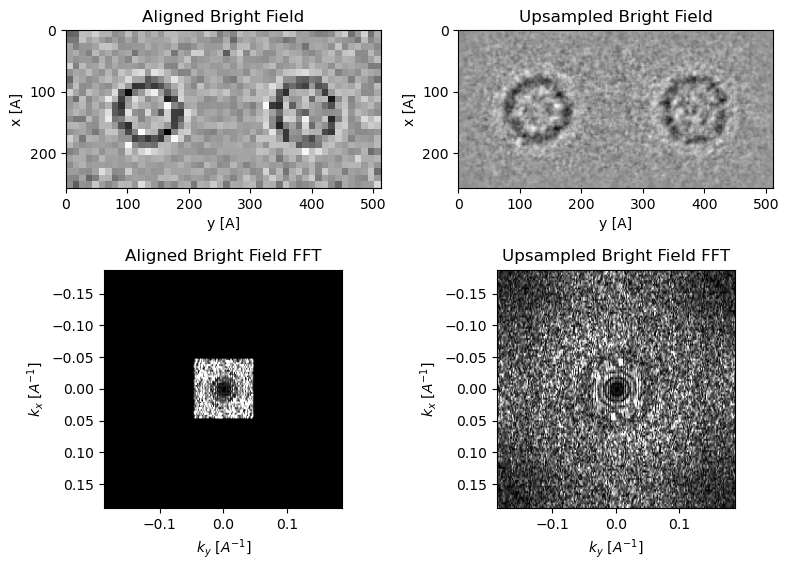

In [16]:
#| label: app:py4dstem_parallax_subpixel

with plt.ioff():
    parallax = parallax.subpixel_alignment(
        kde_upsample_factor=4,
        plot_upsampled_BF_comparison=True,
        plot_upsampled_FFT_comparison=True,
        figsize=(8,6),
        cmap='gray'
    )
    fig_alignment = plt.gcf()
fig_alignment

### Aberration Fitting

Rotation of Q w.r.t. R = -12.790 deg
Astigmatism (A1x,A1y)  = (560,-1010) Ang
Aberration C1          =  -14202 Ang
Defocus dF             = 14202 Ang
Transpose              = False


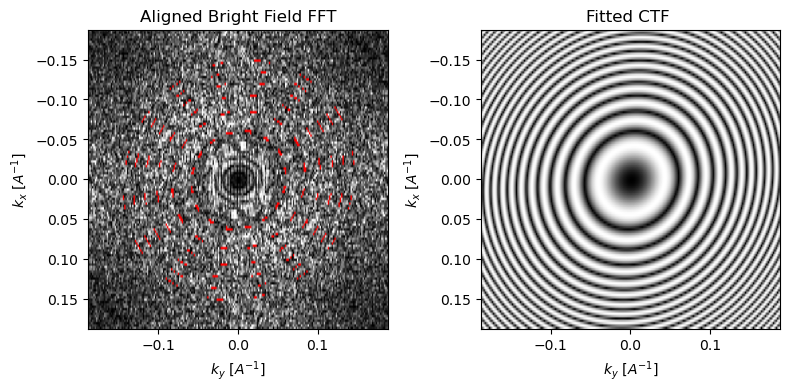

In [17]:
#| label: app:py4dstem_parallax_fitting

with plt.ioff():
    parallax = parallax.aberration_fit(
        plot_CTF_comparison=True,
    )
    fig_fitting = plt.gcf()
fig_fitting

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -12.790 deg
Astigmatism (A1x,A1y)  = (560,-1010) Ang
Aberration C1          =  -14202 Ang
Defocus dF             = 14202 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -14209
stig            2        2         y      -1011
stig            2        2         x      559
coma            3        1         y      -53920
coma            3        1         x      -102269
trefoil         3        3         x      -70
trefoil         3        3         y      137


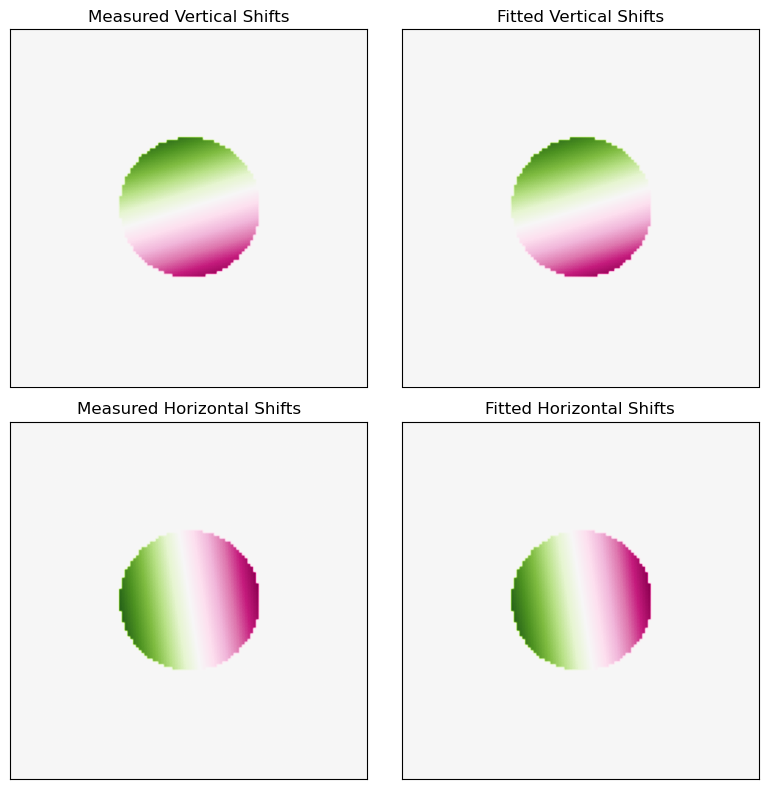

In [18]:
#| label: app:py4dstem_parallax_fitting_higher

with plt.ioff():
    parallax = parallax.aberration_fit(
        fit_BF_shifts=True,
        fit_aberrations_max_radial_order=3,
        fit_aberrations_max_angular_order=3,
        plot_BF_shifts_comparison=True,
    )
    fig_fitting_higher = plt.gcf()
fig_fitting_higher

### Aberration Correction

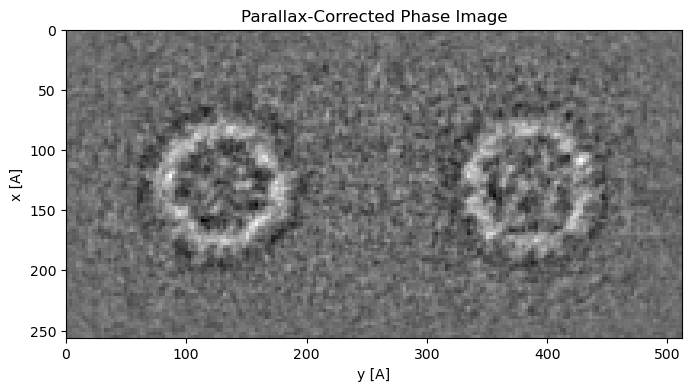

In [19]:
#| label: app:py4dstem_parallax_correction

with plt.ioff():
    parallax = parallax.aberration_correct(
        figsize=(8,4),
        cmap='gray'
    )
    fig_correction = plt.gcf()
fig_correction